# Recurrent Neural Network - RNN

In [2]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22414 sha256=5d35d522071ba2036534d45f75f0c54109733670a945e0e2dccd1953ab0922e0
  Stored in directory: C:\Users\pc\AppData\Local\pip\Cache\wheels\f9\e3\5b\ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
  Created wheel for multitasking: filename=multitasking-0.0.9-cp37-none-any.whl size=8373 sha256=ac9b0d7adddff5d6ca34a11d107a4630c1a3a7b49f8f75514efb74724c2c15c8
  Stored in directory: C:\Users\pc\AppData\Local\pip\Cache\wheels\37\fa\73\d492849e319038eb4d986f5152e4b19ffb1bc0639da84d2677
Successfully built yfinance multitasking
Note: you may need to restart the kernel to use updated packages.


In [8]:
import matplotlib.pyplot as plt 
import yfinance as yf
import pandas as pd 
import numpy as np 
import seaborn as sns 
from datetime import datetime, timedelta, timezone

import warnings 
warnings.filterwarnings('ignore') 

In [10]:
hisseler = ['AAPL']
hisse_fiyatlari = yf.download(hisseler, start='2016-01-01', end= "2019-09-01", interval='1d', prepost=True)

hisse_fiyatlari['Average']= (hisse_fiyatlari['High']+ hisse_fiyatlari['Low'])/2

hisse_fiyatlari.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2015-12-31,107.010002,107.029999,104.820000,105.260002,97.864746,40912300,105.924999
2016-01-04,102.610001,105.370003,102.000000,105.349998,97.948441,67649400,103.685001
2016-01-05,105.750000,105.849998,102.410004,102.709999,95.493919,55791000,104.130001
2016-01-06,100.559998,102.370003,99.870003,100.699997,93.625145,68457400,101.120003
2016-01-07,98.680000,100.129997,96.430000,96.449997,89.673714,81094400,98.279999


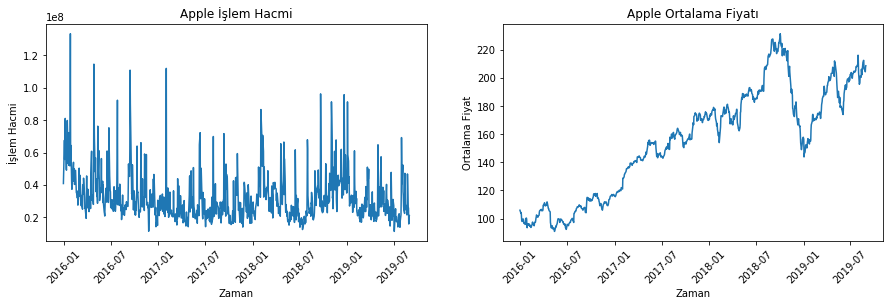

In [12]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.lineplot(x=hisse_fiyatlari.index, y=hisse_fiyatlari.Volume)
plt.title("Apple İşlem Hacmi")
plt.xlabel("Zaman")
plt.ylabel("İşlem Hacmi")
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(x=hisse_fiyatlari.index , y= hisse_fiyatlari.Average)
plt.title("Apple Ortalama Fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Ortalama Fiyat")
plt.xticks(rotation=45)

plt.show()

Tahmin için işlem hacmi ve ortalama sütunlarını bir diziye atalım ve 0 ile 1 arasında olacak şekilde standardize edelim.

In [14]:
girdi_veriler = hisse_fiyatlari.iloc[: , [5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
girdi_veriler[:,0:2]= sc.fit_transform(girdi_veriler[:,:])

In [16]:
girdi_veriler

array([[0.24220029, 0.10718091],
       [0.46134301, 0.0912707 ],
       [0.36414915, 0.09443144],
       ...,
       [0.03751239, 0.80747926],
       [0.07891715, 0.8321259 ],
       [0.08017035, 0.83805666]])

In [17]:
hisse_fiyatlari.shape

(923, 7)

Hisse senedi fiyatlarını tahmin ederken son 50 işlem günündeki fiatları ve işlem hacmini kullanacağız. Verimizin %30'unu da test kümesi olarak kullanacağız. Hedef değişkenimiz de bugün ki fiyat olacak ve bu şekilde devam edecek.

Öncelikle X ve y verilerini hazırlayalım.

In [18]:
lookback = 50 

test_size = int(.3 *len(hisse_fiyatlari))

X= []
y=[]

for i in range(len(hisse_fiyatlari)- lookback -1):
    t=[]
    
    for j in range(0,lookback):
        
        t.append(girdi_veriler[[(i+j)],:])
    X.append(t)
    y.append(girdi_veriler[i+lookback, 1])

In [19]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.23527777 0.09716599]]
0.0971659934385799
-----------
[[0.13152203 0.10515662]]
0.10515661772073315


Verilerimiz başarılı bir şekilde hazırladık. LSTM girdi verisi olarak 3 boyutlu bir veriye ihtiyaç duymaktadır. Bunlar veri sayısı, test adımı sayısı, girdi olarak kullanılacak özellik sayısıdır. Bunu reshape ile yapabiliriz.

In [20]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(872, 50, 2)
(326, 50, 2)


In [55]:
from keras import Sequential
from keras.layers import Dense, LSTM, GRU

In [22]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 30)            3960      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.fit(X, y, epochs=200, batch_size=32, verbose=0)

In [25]:
tahmin_değerleri= model.predict(X_test)

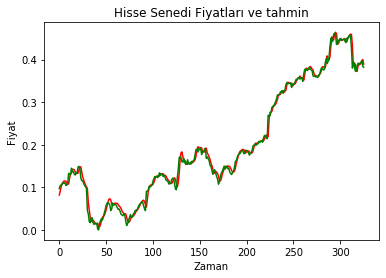

In [27]:
plt.plot(tahmin_değerleri, color= 'red')
plt.plot(girdi_veriler[lookback:test_size+(2*lookback),1], color='green')
plt.title("Hisse Senedi Fiyatları ve tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.show()

# INTL Ve MSFT 

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, timezone
import warnings
warnings.filterwarnings('ignore')

In [7]:
import yfinance as yf

INTL = yf.download("INTL", start="2017-01-01", end="2018-01-1",interval = "1d")
MSFT = yf.download("MSFT", start="2017-01-01", end="2018-01-1",interval = "1d")

MSFT['Average']= (MSFT['High']+ MSFT['Low'])/2
INTL['Average'] = (INTL['High']+ INTL['Low'])/2

INTL.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2017-01-03,39.990002,40.680000,39.650002,40.410000,40.410000,115300,40.165001
2017-01-04,40.470001,41.099998,40.189999,40.860001,40.860001,80600,40.644999
2017-01-05,40.799999,40.799999,38.639999,38.770000,38.770000,127100,39.719999
2017-01-06,38.529999,39.180000,38.389999,38.709999,38.709999,101500,38.785000
2017-01-09,38.580002,38.840000,38.000000,38.330002,38.330002,116300,38.420000


In [8]:
MSFT.head()

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,58.969059,20694100,62.485001
2017-01-04,62.480000,62.750000,62.119999,62.299999,58.705212,21340000,62.434999
2017-01-05,62.189999,62.660000,62.029999,62.299999,58.705212,24876000,62.344999
2017-01-06,62.299999,63.150002,62.040001,62.840000,59.214054,19922900,62.595001
2017-01-09,62.759998,63.080002,62.540001,62.639999,59.025597,20382700,62.810001


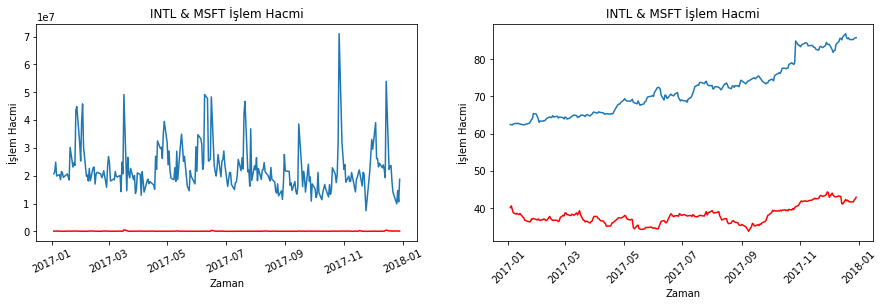

In [31]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
sns.lineplot(x = INTL.index, y = INTL.Volume,color="red")
plt.plot(MSFT.Volume)

plt.title("INTL & MSFT İşlem Hacmi")
plt.xlabel("Zaman")
plt.ylabel("İşlem Hacmi")
plt.xticks(rotation = 25)

plt.subplot(122)
sns.lineplot(x = INTL.index, y = INTL.Average,color="red")
plt.plot(MSFT.Average)
plt.title("INTL & MSFT İşlem Hacmi")
plt.xlabel("Zaman")
plt.ylabel("İşlem Hacmi")
plt.xticks(rotation = 45)

plt.show()

In [11]:
girdi_verileri_INTL = INTL.iloc[:,[5,6]].values
girdi_verileri_MSFT = MSFT.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
girdi_verileri_INTL[:,0:2] = sc.fit_transform(girdi_verileri_INTL[:,:])
girdi_verileri_MSFT[:,0:2] = sc.fit_transform(girdi_verileri_MSFT[:,:])

In [12]:
lookback= 50

test_size=int(.3 * len(INTL))
X=[]
y=[]
for i in range(len(INTL)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(girdi_verileri_INTL[[(i+j)], :])
    X.append(t)
    y.append(girdi_verileri_INTL[i+ lookback,1])

In [13]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.09005932 0.52479904]]
0.5247990436769281
-----------
[[0.0523099  0.48464796]]
0.4846479622184634


In [14]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(200, 50, 2)
(125, 50, 2)


In [22]:
from keras import Sequential
from keras.layers import Dense, LSTM, GRU

model = Sequential()
model.add(LSTM(units=60, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 60)            15120     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 50)            22200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 47,071
Trainable params: 47,071
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=200, batch_size=32, verbose=0)

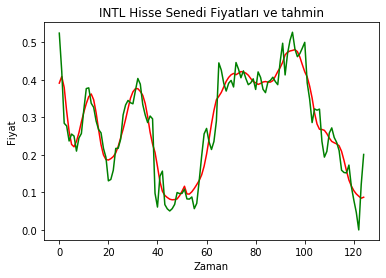

In [18]:
tahmin_değerleri= model.predict(X_test)

plt.plot(tahmin_değerleri, color= 'red')
plt.plot(girdi_verileri_INTL[lookback:test_size+(2*lookback),1], color='green')
plt.title("INTL Hisse Senedi Fiyatları ve tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.show()


In [19]:
lookback= 50

test_size=int(.3 * len(MSFT))
X=[]
y=[]
for i in range(len(MSFT)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(girdi_verileri_MSFT[[(i+j)], :])
    X.append(t)
    y.append(girdi_verileri_MSFT[i+ lookback,1])

In [20]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.20817836 0.08911106]]
0.08911105505228356
-----------
[[0.17724552 0.41741442]]
0.41741441804519663


In [21]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(200, 50, 2)
(125, 50, 2)


In [62]:
model = Sequential()
model.add(LSTM(units=80, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(GRU(units=60, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50, 80)            26560     
_________________________________________________________________
gru_7 (GRU)                  (None, 50, 60)            25560     
_________________________________________________________________
gru_8 (GRU)                  (None, 50, 50)            16800     
_________________________________________________________________
lstm_23 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 78,671
Trainable params: 78,671
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=250, batch_size=32, verbose=0)

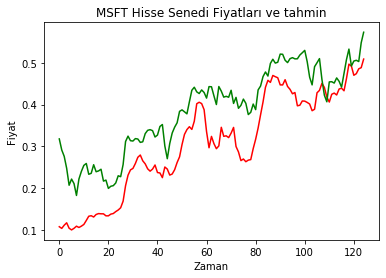

In [65]:
tahmin_değerleri= model.predict(X_test)

plt.plot(tahmin_değerleri, color= 'red')
plt.plot(girdi_verileri_SPY[lookback:test_size+(2*lookback),1], color='green')
plt.title("MSFT Hisse Senedi Fiyatları ve tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.show()